In [2]:
#=======================================================================================
# P-TUNING NLI(Natural Language Interference:자연어 추론) 훈련 예제
#
# => input_ids : [CLS]senetence1(전제)[SEP]sentence2(가설)
# => attention_mask : 1111111111(전체,가설)0000000(그외)
# => token_type_ids : 0000000(전제)1111111(가설)00000000(그외)
# => laels : 참(수반:entailment), 거짓(모순:contradiction), 모름(중립:neutral)
#
#
# prefix-tuning => GPT-2, T5등 LM에서 접두사 prompt를 추가하여 훈련시키는 방식
#
# p-tuning => P-tuning은 prefix-tuning보다 유연 합니다. 
# 시작할 때뿐만 아니라 프롬프트 중간에 학습 가능한 토큰을 삽입하기 때문입니다. 
# https://github.com/THUDM/P-tuning
#
# p-tuing v2 => 새로운 방식이 아니라 NLU 향상을 위해, MLM 모델에 prefix-tuning을 적용한 방식
# https://github.com/THUDM/P-tuning-v2
#=======================================================================================
import numpy as np
import pandas as pd
import torch
from transformers import AutoConfig, AutoTokenizer, set_seed
import os
from os import sys
from transformers import BertTokenizer, HfArgumentParser, TrainingArguments

sys.path.append('..')
from myutils import seed_everything, GPU_info, mlogging
from tqdm.notebook import tqdm


logger = mlogging(loggername="bert-p-tuing", logfilename="bert-p-tuing")
device = GPU_info()

model_path = '../../data11/model/bert/bert-multilingual-cased'

#tokenize 설정
#tokenizer = AutoTokenizer.from_pretrained(model_path, TOKENIZERS_PARALLELISM=True)
tokenizer = BertTokenizer.from_pretrained(model_path, do_lower_case=False)


logfilepath:bert-p-tuing_2022-07-12.log
True
device: cuda:0
cuda index: 0
gpu 개수: 1
graphic name: NVIDIA A30


In [3]:
# 인자들 설정
#======================================================
# data args 인자 설정 
class data_args:
    dataset_name='rte'
    pad_to_max_length = True
    max_seq_length = 128
    overwrite_cache = True
    max_train_samples = None
    max_eval_samples = None
    max_predict_samples = None
    
#======================================================

#======================================================
# 허깅페이스 TrainingArguments 설정
training_args = TrainingArguments("p-tuning-bert-test")

# run_rte_bert.sh 에 사용된 인자만 새롭게 정의함.
training_args.do_train=True
training_args.do_eval=True
training_args.seed = 111
training_args.per_device_train_batch_size=32  #batch_size
training_args.learning_rate =3e-5        #lr
training_args.save_strategy = "no"
training_args.evaluation_strategy = "steps"  #eval 언제마다 할지 => no, steps, epoch
training_args.num_train_epochs=50 # epochs
training_args.output_dir = '../../data11/model/bert/bert-multilingual-cased-p-tuing-pp-nli-20'

#training_args.report_to = "none"  # 기본은 all로 , all이면 wandb에도 기록된다.
#======================================================
   
#======================================================
# p-tuningv2 prefixt 튜닝일때 설정값 지정 
pre_seq_len = 20             # prefix 계수
prefix_projection = True     # True = two-layer MLP 사용함(Multi-layer perceptron(다중퍼셉트론))
prefix_hidden_size = 512     # prefix hidden size
#======================================================

#======================================================
#seed 설정
#set_seed(training_args.seed)
seed_everything(training_args.seed)
#======================================================

print(training_args.fp16)
print(training_args.get_process_log_level())
print(training_args.do_train)
print(training_args.evaluation_strategy)
print(training_args.learning_rate)

False
20
True
steps
3e-05


In [4]:
#nli 데이터 셋 로딩
# 학습 data loader 생성
#sys.path.append('..')
from myutils import ClassificationDataset, KlueNLICorpus, data_collator
from torch.utils.data import DataLoader, RandomSampler

#############################################################################
# 변수 설정
#############################################################################
max_seq_len = data_args.max_seq_length   # 글자 최대 토큰 길이 해당 토큰 길이 이상은 잘린다.
batch_size = training_args.per_device_train_batch_size        # 배치 사이즈(64면 GUP Memory 오류 나므로, 32 이하로 설정할것=>max_seq_length 를 줄이면, 64도 가능함)

# 훈련할 csv 파일
file_fpath = '../../data11/korpora/klue-nli/klue-nli-v1.1_train.json'
#file_fpath = 'Korpora/nsmc/ratings_train.txt'
cache = True   # 캐쉬파일 생성할거면 True로 (True이면 loding할때 캐쉬파일있어도 이용안함)
#############################################################################

# corpus 파일 설정
corpus = KlueNLICorpus()

# 학습 dataset 생성
dataset = ClassificationDataset(file_fpath=file_fpath,max_seq_length=max_seq_len, tokenizer=tokenizer, corpus=corpus, overwrite_cache=cache)


# 학습 dataloader 생성
train_loader = DataLoader(dataset, 
                          batch_size=batch_size, 
                          #shuffle=True, # dataset을 섞음
                          sampler=RandomSampler(dataset, replacement=False), #dataset을 랜덤하게 샘플링함
                          collate_fn=data_collator, # dataset을 tensor로 변환(예시 {'input_ids':tensor[0,1,2,3,1,], 'token_type_id:tensor[0,0,0,0,0], 'attention_mask:tensor[1,1,1,1,1], 'labels':tensor[5]}
                          num_workers=4)

# 평가 dataset 생성
file_fpath = '../../data11/korpora/klue-nli/klue-nli-v1.1_dev.json'
dataset = ClassificationDataset(file_fpath=file_fpath, max_seq_length=max_seq_len, tokenizer=tokenizer, corpus=corpus, overwrite_cache=cache)

# 평가 dataloader 생성
eval_loader = DataLoader(dataset, 
                          batch_size=batch_size, 
                          #shuffle=True, # dataset을 섞음
                          sampler=RandomSampler(dataset, replacement=False), #dataset을 랜덤하게 샘플링함
                          collate_fn=data_collator, # dataset을 tensor로 변환(예시 {'input_ids':tensor[0,1,2,3,1,], 'token_type_id:tensor[0,0,0,0,0], 'attention_mask:tensor[1,1,1,1,1], 'labels':tensor[5]}
                          num_workers=4)

Creating features from dataset file at ../../data11/korpora/klue-nli/klue-nli-v1.1_train.json
loading data... LOOKING AT ../../data11/korpora/klue-nli/klue-nli-v1.1_train.json
tokenize sentences, it could take a lot of time...


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


tokenize sentences [took %.3f s] 7.264301300048828


  0%|          | 0/24998 [00:00<?, ?it/s]

*** Example ***
sentence A, B: 힛걸 진심 최고다 그 어떤 히어로보다 멋지다 + 힛걸 진심 최고로 멋지다.
tokens: [CLS] [UNK] 진 ##심 최고 ##다 그 어떤 히 ##어로 ##보다 멋 ##지 ##다 [SEP] [UNK] 진 ##심 최고 ##로 멋 ##지 ##다 . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
label: entailment
features: ClassificationFeatures(input_ids=[101, 100, 9708, 71013, 83491, 11903, 8924, 55910, 10025, 81483, 80001, 9270, 12508, 11903, 102, 100, 9708, 71013, 83491, 11261, 9270, 12508, 119

  0%|          | 0/3000 [00:00<?, ?it/s]

*** Example ***
sentence A, B: 흡연자분들은 발코니가 있는 방이면 발코니에서 흡연이 가능합니다. + 어떤 방에서도 흡연은 금지됩니다.
tokens: [CLS] 흡 ##연 ##자 ##분 ##들은 발 ##코 ##니 ##가 있는 방 ##이 ##면 발 ##코 ##니 ##에서 흡 ##연 ##이 가 ##능 ##합 ##니다 . [SEP] 어떤 방 ##에서 ##도 흡 ##연 ##은 [UNK] . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
label: contradiction
features: ClassificationFeatures(input_ids=[101, 10020, 25486, 13764, 37712, 22879, 9323, 25517, 25503, 11287, 13767, 9328, 10739, 14867, 9323, 25517, 25503, 11489, 10020, 25486, 10739, 8843, 74986, 

In [5]:
# config 설정 
config = AutoConfig.from_pretrained(
    model_path,
    num_labels=3,  #nli이므로 3으로 함
    #label2id=dataset.label2id,
    #id2label=dataset.id2label,
    finetuning_task=data_args.dataset_name,
    revision="main"
)

#========================================================================
# 훈련 모델에 따라 아래값들을 바꿔줘야 함.
#========================================================================
#get_model 에서 --prefix인경우 config 인자 설정해 주고 있음.

config.hidden_dropout_prob = 0.1
config.pre_seq_len = pre_seq_len             # prefix 계수
config.prefix_projection = prefix_projection    # True = two-layer MLP 사용함(Multi-layer perceptron(다중퍼셉트론))
config.prefix_hidden_size = prefix_hidden_size     # prefix hidden size
#========================================================================

print(config.num_hidden_layers)
print(config.num_attention_heads)
print(config.hidden_size)

12
12
768


In [6]:
#==============================================================================
# p-tuing v2 => 새로운 방식이 아니라 NLU 향상을 위해, MLM 모델에 prefix-tuning을 적용한 방식
# 참고 소스 : https://github.com/THUDM/P-tuning-v2
#==============================================================================

import copy
import torch
from torch._C import NoopLogger
import torch.nn
import torch.nn.functional as F
from torch import Tensor
from torch.nn import CrossEntropyLoss, MSELoss, BCEWithLogitsLoss
from transformers import BertModel, BertPreTrainedModel
from transformers.modeling_outputs import SequenceClassifierOutput, BaseModelOutput, Seq2SeqLMOutput

class PrefixEncoder(torch.nn.Module):
    r'''
    The torch.nn model to encode the prefix
    Input shape: (batch-size, prefix-length)
    Output shape: (batch-size, prefix-length, 2*layers*hidden)
    '''
    def __init__(self, config):
        super().__init__()
        self.prefix_projection = config.prefix_projection
        if self.prefix_projection:
            # Use a two-layer MLP to encode the prefix
            self.embedding = torch.nn.Embedding(config.pre_seq_len, config.hidden_size)
            self.trans = torch.nn.Sequential(
                torch.nn.Linear(config.hidden_size, config.prefix_hidden_size),
                torch.nn.Tanh(),
                torch.nn.Linear(config.prefix_hidden_size, config.num_hidden_layers * 2 * config.hidden_size)
            )
        else:
            self.embedding = torch.nn.Embedding(config.pre_seq_len, config.num_hidden_layers * 2 * config.hidden_size)

    def forward(self, prefix: torch.Tensor):
        if self.prefix_projection:
            prefix_tokens = self.embedding(prefix)
            past_key_values = self.trans(prefix_tokens)
        else:
            past_key_values = self.embedding(prefix)
        return past_key_values
    
class BertPrefixForSequenceClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config
        self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        self.classifier = torch.nn.Linear(config.hidden_size, config.num_labels)

        # ***bert 모델은 grad 업데이트 안함(역전파 끔)
        for param in self.bert.parameters():
            param.requires_grad = False
        
        self.pre_seq_len = config.pre_seq_len
        self.n_layer = config.num_hidden_layers  # 12
        self.n_head = config.num_attention_heads # 12
        self.n_embd = config.hidden_size // config.num_attention_heads  # 64 = 768 % 12

        self.prefix_tokens = torch.arange(self.pre_seq_len).long()
        self.prefix_encoder = PrefixEncoder(config)

        bert_param = 0
        for name, param in self.bert.named_parameters():
            bert_param += param.numel()
        all_param = 0
        for name, param in self.named_parameters():
            all_param += param.numel()
        total_param = all_param - bert_param
        print('total param is {}'.format(total_param)) # 9860105
    
    def get_prompt(self, batch_size):
        # [32,20] 만듬 (32:batch_size, 20 은 self.prefix_tokens arange로 생성한 값)
        prefix_tokens = self.prefix_tokens.unsqueeze(0).expand(batch_size, -1).to(self.bert.device)
        #print(f'prefix_tokens=>{prefix_tokens.shape}')
        
        past_key_values = self.prefix_encoder(prefix_tokens)
        #print(f'past_key_values1=>{past_key_values.shape}')
            
        # bsz, seqlen, _ = past_key_values.shape
        past_key_values = past_key_values.view(
            batch_size,
            self.pre_seq_len,
            self.n_layer * 2, 
            self.n_head,
            self.n_embd
        )
        # batch_size:32, pre_seq_len:20, nlayer:12, nhead:12, n_emb:64
        #print(f'*batch_size:{batch_size}, pre_seq_len:{self.pre_seq_len}, nlayer:{self.n_layer}, nhead:{self.n_head}, n_emb:{self.n_embd}') 
        
        #print(f'past_key_values2=>{past_key_values.shape}')  # torch.Size([32, 20, 24, 12, 64])
            
        past_key_values = self.dropout(past_key_values)
        #print(f'past_key_values3=>{past_key_values.shape}')  # torch.Size([32, 20, 24, 12, 64])
            
        past_key_values = past_key_values.permute([2, 0, 3, 1, 4]).split(2)
        # torch.Size([2, 32, 12, 20, 64]), len"12
        #print(f'past_key_values4=>{past_key_values[0].shape}, len"{len(past_key_values)}')
        
        return past_key_values

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        #print(f'return_dict=>{return_dict}') # True
            
        batch_size = input_ids.shape[0]
        
        # past_key_values 는 디코딩할때 빠르게 찾기 위한 값인데..여기서는 왜 필요한지 모르겠음.
        past_key_values = self.get_prompt(batch_size=batch_size)
        
        prefix_attention_mask = torch.ones(batch_size, self.pre_seq_len).to(self.bert.device)
        #print(f'prefix_attention_mask=>{prefix_attention_mask.shape}') # torch.Size([32, 20])
        
        #print(f'attention_mask1=>{attention_mask.shape}') # torch.Size([32, 128])
        attention_mask = torch.cat((prefix_attention_mask, attention_mask), dim=1) # 128(기존 attention_mask) + 20(prefix_attention_mask) = 148
        #print(f'*attention_mask2=>{attention_mask.shape}') # torch.Size([32, 148])

        #print(f'*input_ids=>{input_ids.shape}')
        #print(f'*token_type_ids=>{token_type_ids.shape}')
        #print(f'*past_key_values=>{past_key_values[0].shape}')
        
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            past_key_values=past_key_values,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [7]:
from transformers import BertForSequenceClassification

# p-tuning 모델
model = BertPrefixForSequenceClassification.from_pretrained(model_path, config=config, revision="main")

# NLI 모델에서 레벨은 3개지(참,거짓,모름) 이므로, num_labels=3을 입력함
#model = BertForSequenceClassification.from_pretrained(model_path, num_labels=3)

model.to(device)

total param is 9867011


Some weights of the model checkpoint at ../../data11/model/bert/bert-multilingual-cased were not used when initializing BertPrefixForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertPrefixForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertPrefixForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertPrefixForSequenceClassifica

BertPrefixForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [8]:
# 학습 시작
import time
from transformers import AdamW, get_linear_schedule_with_warmup

logger.info(f"=== model: {model_path} ===")
logger.info(f"num_parameters: {model.num_parameters()}")

##################################################
# 변수 설정
##################################################
epochs = training_args.num_train_epochs            # epochs
learning_rate = training_args.learning_rate  # 학습률
p_itr = 400           # 손실률 보여줄 step 수
##################################################

# optimizer 적용
optimizer = AdamW(model.parameters(), 
                 lr=learning_rate, 
                 eps=1e-8) # 0으로 나누는 것을 방지하기 위한 epsilon 값(10^-6 ~ 10^-8 사이 이값 입력합)

# 총 훈련과정에서 반복할 스탭
total_steps = len(train_loader)*epochs

num_warmup_steps = total_steps * 0.1

# 스캐줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=num_warmup_steps, 
                                            num_training_steps=total_steps)

itr = 1
total_loss = 0
total_len = 0
total_correct = 0
list_training_loss = []
list_acc_loss = []
list_validation_acc_loss = []

model.zero_grad()# 그래디언트 초기화
for epoch in tqdm(range(epochs)):

    model.train() # 훈련모드로 변환
    for data in tqdm(train_loader):
    
        #optimizer.zero_grad()
        model.zero_grad()# 그래디언트 초기화
        
        # 입력 값 설정
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)       
        labels = data['labels'].to(device)
        #print('Labels:{}'.format(labels))
        
        # 모델 실행
        outputs = model(input_ids=input_ids, 
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=labels)
        
        # 출력값 loss,logits를 outputs에서 얻어옴
        loss = outputs.loss
        logits = outputs.logits
        #print('Loss:{}, logits:{}'.format(loss, logits))
        
        # optimizer 과 scheduler 업데이트 시킴
        loss.backward()   # backward 구함
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)   # 그래디언트 클리핑 (gradient vanishing이나 gradient exploding 방지하기 위한 기법)
        optimizer.step()  # 가중치 파라미터 업데이트(optimizer 이동)
        scheduler.step()  # 학습률 감소
        
        # 정확도와 손실률 계산하는 부분은 no_grade 시켜서, 계산량을 줄임.
        # => torch.no_grad()는 gradient을 계산하는 autograd engine를 비활성화 하여 
        # 필요한 메모리를 줄이고, 연산속도를 증가시키는 역활을 함
        with torch.no_grad():
            # 정확도와 총 손실률 계산
            pred = torch.argmax(F.softmax(logits), dim=1)
            correct = pred.eq(labels)
            total_correct += correct.sum().item()
            total_len += len(labels)    
            total_loss += loss.item()
            #print('pred:{}, correct:{}'.format(pred, correct))

            # 주기마다 test(validataion) 데이터로 평가하여 손실류 계산함.
            if itr % p_itr == 0:

                logger.info('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Train Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, total_correct/total_len))

                list_training_loss.append(total_loss/p_itr)
                list_acc_loss.append(total_correct/total_len)

                total_loss = 0
                total_len = 0
                total_correct = 0

        itr+=1
        
        #if itr > 5:
        #    break
   
    ####################################################################
    # 1epochs 마다 실제 test(validattion)데이터로 평가 해봄
    start = time.time()
    logger.info(f'---------------------------------------------------------')

    # 평가 시작
    model.eval()
    
    total_test_correct = 0
    total_test_len = 0
    
    for data in tqdm(eval_loader):
        # 입력 값 설정
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)       
        labels = data['labels'].to(device)
 
        # 손실률 계산하는 부분은 no_grade 시켜서, 계산량을 줄임.
        # => torch.no_grad()는 gradient을 계산하는 autograd engine를 비활성화 하여 
        # 필요한 메모리를 줄이고, 연산속도를 증가시키는 역활을 함
        with torch.no_grad():
            # 모델 실행
            outputs = model(input_ids=input_ids, 
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            labels=labels)
    
            # 출력값 loss,logits를 outputs에서 얻어옴
            #loss = outputs.loss
            logits = outputs.logits
    
            # 총 손실류 구함
            pred = torch.argmax(F.softmax(logits), dim=1)
            correct = pred.eq(labels)
            total_test_correct += correct.sum().item()
            total_test_len += len(labels)
    
    list_validation_acc_loss.append(total_test_correct/total_test_len)
    logger.info("[Epoch {}/{}] Validatation Accuracy:{}".format(epoch+1, epochs, total_test_correct / total_test_len))
    logger.info(f'---------------------------------------------------------')
    logger.info(f'=== 처리시간: {time.time() - start:.3f} 초 ===')
    logger.info(f'-END-\n')
    ####################################################################

2022-07-12 17:29:55,852 - bert-p-tuing - INFO - [Epoch 40/50] Iteration 31200 -> Train Loss: 0.5740, Train Accuracy: 0.764
2022-07-12 17:30:02,078 - bert-p-tuing - INFO - ---------------------------------------------------------


  0%|          | 0/94 [00:00<?, ?it/s]

2022-07-12 17:30:06,093 - bert-p-tuing - INFO - [Epoch 40/50] Validatation Accuracy:0.6853333333333333
2022-07-12 17:30:06,095 - bert-p-tuing - INFO - ---------------------------------------------------------
2022-07-12 17:30:06,095 - bert-p-tuing - INFO - === 처리시간: 4.018 초 ===
2022-07-12 17:30:06,096 - bert-p-tuing - INFO - -END-



  0%|          | 0/782 [00:00<?, ?it/s]

2022-07-12 17:30:30,931 - bert-p-tuing - INFO - [Epoch 41/50] Iteration 31600 -> Train Loss: 0.5768, Train Accuracy: 0.766
2022-07-12 17:31:02,054 - bert-p-tuing - INFO - [Epoch 41/50] Iteration 32000 -> Train Loss: 0.5788, Train Accuracy: 0.765
2022-07-12 17:31:07,033 - bert-p-tuing - INFO - ---------------------------------------------------------


  0%|          | 0/94 [00:00<?, ?it/s]

2022-07-12 17:31:11,081 - bert-p-tuing - INFO - [Epoch 41/50] Validatation Accuracy:0.687
2022-07-12 17:31:11,083 - bert-p-tuing - INFO - ---------------------------------------------------------
2022-07-12 17:31:11,084 - bert-p-tuing - INFO - === 처리시간: 4.051 초 ===
2022-07-12 17:31:11,084 - bert-p-tuing - INFO - -END-



  0%|          | 0/782 [00:00<?, ?it/s]

2022-07-12 17:31:37,503 - bert-p-tuing - INFO - [Epoch 42/50] Iteration 32400 -> Train Loss: 0.5736, Train Accuracy: 0.769
2022-07-12 17:32:08,380 - bert-p-tuing - INFO - [Epoch 42/50] Iteration 32800 -> Train Loss: 0.5810, Train Accuracy: 0.761
2022-07-12 17:32:11,984 - bert-p-tuing - INFO - ---------------------------------------------------------


  0%|          | 0/94 [00:00<?, ?it/s]

2022-07-12 17:32:15,989 - bert-p-tuing - INFO - [Epoch 42/50] Validatation Accuracy:0.688
2022-07-12 17:32:15,990 - bert-p-tuing - INFO - ---------------------------------------------------------
2022-07-12 17:32:15,991 - bert-p-tuing - INFO - === 처리시간: 4.007 초 ===
2022-07-12 17:32:15,991 - bert-p-tuing - INFO - -END-



  0%|          | 0/782 [00:00<?, ?it/s]

2022-07-12 17:32:43,472 - bert-p-tuing - INFO - [Epoch 43/50] Iteration 33200 -> Train Loss: 0.5703, Train Accuracy: 0.765
2022-07-12 17:33:14,296 - bert-p-tuing - INFO - [Epoch 43/50] Iteration 33600 -> Train Loss: 0.5767, Train Accuracy: 0.766
2022-07-12 17:33:16,466 - bert-p-tuing - INFO - ---------------------------------------------------------


  0%|          | 0/94 [00:00<?, ?it/s]

2022-07-12 17:33:20,505 - bert-p-tuing - INFO - [Epoch 43/50] Validatation Accuracy:0.689
2022-07-12 17:33:20,506 - bert-p-tuing - INFO - ---------------------------------------------------------
2022-07-12 17:33:20,507 - bert-p-tuing - INFO - === 처리시간: 4.041 초 ===
2022-07-12 17:33:20,508 - bert-p-tuing - INFO - -END-



  0%|          | 0/782 [00:00<?, ?it/s]

2022-07-12 17:33:49,402 - bert-p-tuing - INFO - [Epoch 44/50] Iteration 34000 -> Train Loss: 0.5708, Train Accuracy: 0.767
2022-07-12 17:34:20,152 - bert-p-tuing - INFO - [Epoch 44/50] Iteration 34400 -> Train Loss: 0.5747, Train Accuracy: 0.767
2022-07-12 17:34:20,917 - bert-p-tuing - INFO - ---------------------------------------------------------


  0%|          | 0/94 [00:00<?, ?it/s]

2022-07-12 17:34:24,949 - bert-p-tuing - INFO - [Epoch 44/50] Validatation Accuracy:0.6906666666666667
2022-07-12 17:34:24,951 - bert-p-tuing - INFO - ---------------------------------------------------------
2022-07-12 17:34:24,951 - bert-p-tuing - INFO - === 처리시간: 4.035 초 ===
2022-07-12 17:34:24,952 - bert-p-tuing - INFO - -END-



  0%|          | 0/782 [00:00<?, ?it/s]

2022-07-12 17:34:55,360 - bert-p-tuing - INFO - [Epoch 45/50] Iteration 34800 -> Train Loss: 0.5721, Train Accuracy: 0.767
2022-07-12 17:35:25,415 - bert-p-tuing - INFO - ---------------------------------------------------------


  0%|          | 0/94 [00:00<?, ?it/s]

2022-07-12 17:35:29,404 - bert-p-tuing - INFO - [Epoch 45/50] Validatation Accuracy:0.6903333333333334
2022-07-12 17:35:29,405 - bert-p-tuing - INFO - ---------------------------------------------------------
2022-07-12 17:35:29,406 - bert-p-tuing - INFO - === 처리시간: 3.991 초 ===
2022-07-12 17:35:29,406 - bert-p-tuing - INFO - -END-



  0%|          | 0/782 [00:00<?, ?it/s]

2022-07-12 17:35:30,539 - bert-p-tuing - INFO - [Epoch 46/50] Iteration 35200 -> Train Loss: 0.5724, Train Accuracy: 0.765
2022-07-12 17:36:01,305 - bert-p-tuing - INFO - [Epoch 46/50] Iteration 35600 -> Train Loss: 0.5799, Train Accuracy: 0.764
2022-07-12 17:36:30,008 - bert-p-tuing - INFO - ---------------------------------------------------------


  0%|          | 0/94 [00:00<?, ?it/s]

2022-07-12 17:36:34,041 - bert-p-tuing - INFO - [Epoch 46/50] Validatation Accuracy:0.6913333333333334
2022-07-12 17:36:34,043 - bert-p-tuing - INFO - ---------------------------------------------------------
2022-07-12 17:36:34,043 - bert-p-tuing - INFO - === 처리시간: 4.035 초 ===
2022-07-12 17:36:34,044 - bert-p-tuing - INFO - -END-



  0%|          | 0/782 [00:00<?, ?it/s]

2022-07-12 17:36:36,543 - bert-p-tuing - INFO - [Epoch 47/50] Iteration 36000 -> Train Loss: 0.5648, Train Accuracy: 0.768
2022-07-12 17:37:07,100 - bert-p-tuing - INFO - [Epoch 47/50] Iteration 36400 -> Train Loss: 0.5745, Train Accuracy: 0.764
2022-07-12 17:37:34,454 - bert-p-tuing - INFO - ---------------------------------------------------------


  0%|          | 0/94 [00:00<?, ?it/s]

2022-07-12 17:37:38,505 - bert-p-tuing - INFO - [Epoch 47/50] Validatation Accuracy:0.6886666666666666
2022-07-12 17:37:38,507 - bert-p-tuing - INFO - ---------------------------------------------------------
2022-07-12 17:37:38,507 - bert-p-tuing - INFO - === 처리시간: 4.053 초 ===
2022-07-12 17:37:38,508 - bert-p-tuing - INFO - -END-



  0%|          | 0/782 [00:00<?, ?it/s]

2022-07-12 17:37:42,454 - bert-p-tuing - INFO - [Epoch 48/50] Iteration 36800 -> Train Loss: 0.5697, Train Accuracy: 0.771
2022-07-12 17:38:13,088 - bert-p-tuing - INFO - [Epoch 48/50] Iteration 37200 -> Train Loss: 0.5690, Train Accuracy: 0.772
2022-07-12 17:38:39,157 - bert-p-tuing - INFO - ---------------------------------------------------------


  0%|          | 0/94 [00:00<?, ?it/s]

2022-07-12 17:38:43,201 - bert-p-tuing - INFO - [Epoch 48/50] Validatation Accuracy:0.691
2022-07-12 17:38:43,202 - bert-p-tuing - INFO - ---------------------------------------------------------
2022-07-12 17:38:43,203 - bert-p-tuing - INFO - === 처리시간: 4.046 초 ===
2022-07-12 17:38:43,204 - bert-p-tuing - INFO - -END-



  0%|          | 0/782 [00:00<?, ?it/s]

2022-07-12 17:38:48,613 - bert-p-tuing - INFO - [Epoch 49/50] Iteration 37600 -> Train Loss: 0.5726, Train Accuracy: 0.765
2022-07-12 17:39:19,327 - bert-p-tuing - INFO - [Epoch 49/50] Iteration 38000 -> Train Loss: 0.5765, Train Accuracy: 0.768
2022-07-12 17:39:43,781 - bert-p-tuing - INFO - ---------------------------------------------------------


  0%|          | 0/94 [00:00<?, ?it/s]

2022-07-12 17:39:47,783 - bert-p-tuing - INFO - [Epoch 49/50] Validatation Accuracy:0.6933333333333334
2022-07-12 17:39:47,784 - bert-p-tuing - INFO - ---------------------------------------------------------
2022-07-12 17:39:47,785 - bert-p-tuing - INFO - === 처리시간: 4.004 초 ===
2022-07-12 17:39:47,786 - bert-p-tuing - INFO - -END-



  0%|          | 0/782 [00:00<?, ?it/s]

2022-07-12 17:39:54,394 - bert-p-tuing - INFO - [Epoch 50/50] Iteration 38400 -> Train Loss: 0.5571, Train Accuracy: 0.773
2022-07-12 17:40:25,525 - bert-p-tuing - INFO - [Epoch 50/50] Iteration 38800 -> Train Loss: 0.5679, Train Accuracy: 0.762
2022-07-12 17:40:48,802 - bert-p-tuing - INFO - ---------------------------------------------------------


  0%|          | 0/94 [00:00<?, ?it/s]

2022-07-12 17:40:53,021 - bert-p-tuing - INFO - [Epoch 50/50] Validatation Accuracy:0.6926666666666667
2022-07-12 17:40:53,023 - bert-p-tuing - INFO - ---------------------------------------------------------
2022-07-12 17:40:53,024 - bert-p-tuing - INFO - === 처리시간: 4.222 초 ===
2022-07-12 17:40:53,025 - bert-p-tuing - INFO - -END-



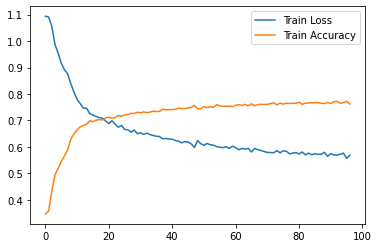

In [9]:
# 그래프로 loss 표기
#!pip install matplotlib
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='Train Loss')
plt.plot(list_acc_loss, label='Train Accuracy')
plt.legend()
plt.show()

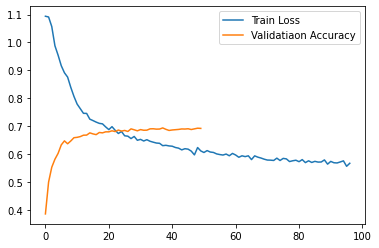

In [10]:
# train loss와 Validatiaon acc 출력
plt.plot(list_training_loss, label='Train Loss')
plt.plot(list_validation_acc_loss, label='Validatiaon Accuracy')
plt.legend()
plt.show()

In [11]:
### 전체모델 저장
OUTPATH = training_args.output_dir

os.makedirs(OUTPATH, exist_ok=True)
#torch.save(model, OUTPATH + 'pytorch_model.bin') 
model.save_pretrained(OUTPATH)  # save_pretrained 로 저장하면 config.json, pytorch_model.bin 2개의 파일이 생성됨

# tokeinizer 파일 저장(vocab)
VOCAB_PATH = OUTPATH
os.makedirs(VOCAB_PATH,exist_ok=True)
tokenizer.save_pretrained(VOCAB_PATH)

('../../data11/model/bert/bert-multilingual-cased-p-tuing-pp-nli-20/tokenizer_config.json',
 '../../data11/model/bert/bert-multilingual-cased-p-tuing-pp-nli-20/special_tokens_map.json',
 '../../data11/model/bert/bert-multilingual-cased-p-tuing-pp-nli-20/vocab.txt',
 '../../data11/model/bert/bert-multilingual-cased-p-tuing-pp-nli-20/added_tokens.json')

In [ ]:
#torch.save(model, OUTPATH + 'pytorch_model_torch.bin') 